In [22]:
using Agents
using CairoMakie
using Makie

using GeometryBasics
using Random
using LinearAlgebra
using Plots
using KernelDensity
using QuadGK
using Interpolations
using StatsBase
using Statistics
using DataFrames
using Loess
using DataStructures

In [3]:
function moving_average(values, window_size)
    len = length(values)
    smoothed_values = zeros(len)
    for i in 1:len
        start_index = max(1, i - window_size + 1)
        end_index = i
        smoothed_values[i] = mean(values[start_index:end_index])
    end
    return smoothed_values
end

function exponential_moving_average(values, α)
    len = length(values)
    EMA = zeros(len)
    EMA[1] = values[1]
    for i in 2:len
        EMA[i] = α * values[i] + (1 - α) * EMA[i-1]
    end
    return EMA
end

exponential_moving_average (generic function with 1 method)

In [6]:
@agent Bird ContinuousAgent{2} begin
    #id, pos, vel (inherited)
    speed::Float64 #how far it travels
    cohere_factor::Float64 #group cohesion importance
    separation::Float64 #minimum distance from neighbors
    separate_factor::Float64 #importance of separation maintanence
    match_factor::Float64 #importance of maintaining similar trajectories
    visual_distance::Float64 #how far agent sees/scan neighbors (radius)
    ensemble::Float64 #number of birds in the flock the bird belongs to
    ensemble_history::CircularBuffer{Float64}
end

In [7]:
SEED = 12;

In [19]:
model_iteration = 0

function initialize_model(; n_birds = 40,
    speed = 2.0,
    cohere_factor = 0.4,
    separation = 4.0, separate_factor = 0.25,
    match_factor = 0.02,
    visual_distance = 5.0,
    ensemble = 1,
    history_length = 8,
    extent = (50, 50) )
    
    global model_iteration = 0
    
    space2d = ContinuousSpace(extent; spacing = visual_distance/1.5)
    rng = Random.MersenneTwister(SEED)

    model = ABM(Bird, space2d; rng, scheduler = Schedulers.Randomly())
    
    for _ in 1:n_birds
        vel = Tuple(rand(model.rng, 2) * 2 .- 1)
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
            ensemble,
            CircularBuffer{Float64}(history_length)
        )
    end
    return model
end


initialize_model (generic function with 1 method)

In [21]:
model = initialize_model()

StandardABM with 40 agents of type Bird
 space: periodic continuous space with (50.0, 50.0) extent and spacing=3.3333333333333335
 scheduler: Agents.Schedulers.Randomly

In [44]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)

    match = separate = cohere = (0.0, 0.0)
    
    angle_threshold = 120 * (pi / 180)
    bird_speed = norm(bird.vel)
    ensemble_count = 0
        
    for id in neighbor_ids
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading

        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
        
        
        neighbor_speed = norm(model[id].speed)        
        angle_between = acos(dot(bird.vel, model[id].vel) / (bird_speed * neighbor_speed + 1e-9))  # Adding a small epsilon to avoid division by zero
        speed_difference = abs(bird_speed - neighbor_speed) / (bird_speed + 1e-9)  # Adding a small epsilon to avoid division by zero
        
        if angle_between < angle_threshold #|| (speed_difference < 2 || speed_difference > 0.5)
            ensemble_count += 1
        end        
                
    end
    
    N = max(length(collect(neighbor_ids)), 1)
    
    # Update the ensemble history
    push!(bird.ensemble_history, length(collect(neighbor_ids)))
    
    bird.ensemble = median(bird.ensemble_history)
    
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    
    #bird.ensemble = ensemble_count
    
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

In [45]:
bird_polygon = Makie.Polygon(Point2f[(-1, -1), (2, 0), (-1, 1)])

function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) #+ π/2 + π
    rotate_polygon(bird_polygon, φ)
end

function Plot_Birds_Iter(model, heat_tmp, iteration_tmp)    
    title_str = "E=$heat_tmp at iter=$iteration_tmp"
    figure, = Agents.abmplot(model; am = bird_marker, aspect = 1, 
                                axis = (; title = title_str, titlesize=20) )
    return figure    
end


Plot_Birds_Iter (generic function with 1 method)

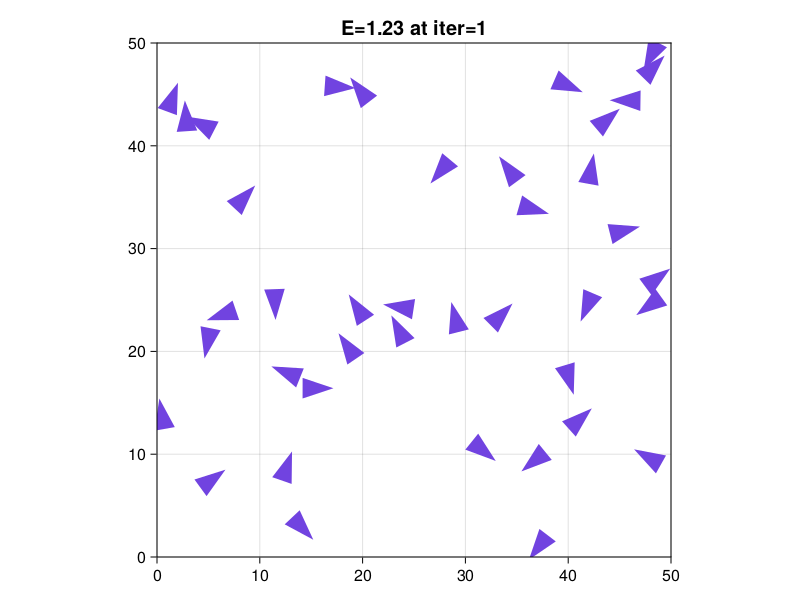

In [46]:
Plot_Birds_Iter(initialize_model(), 1.23, 1)

## Energies



In [47]:
function Model_Ensemble_Energy(model)
    energy = 0
    
    for bird in allagents(model)        
        energy += bird.ensemble
    end
    
    return energy
end

Model_Ensemble_Energy (generic function with 1 method)

In [48]:
function Model_Energy_DistributionFN(model) 
    energies = []

    for bird in allagents(model)
        push!(energies, bird.ensemble)
    end
    
    energies_float = float.(energies)

    hist = fit(Histogram, energies_float, closed=:left)

    total_count = sum(hist.weights)
    pdf = hist.weights ./ total_count

    # This will include the bin centers (or edges) and the corresponding probabilities
    energy_bins = midpoints(hist.edges[1])
    energy_distribution = [(e, p) for (e, p) in zip(energy_bins, pdf)]

    return energy_distribution
end

Model_Energy_DistributionFN (generic function with 1 method)

In [49]:
function Model_Entropy(e_p_array)
    S = 0.0

    for (e, p) in e_p_array
        # Only add to the sum if p is non-zero to avoid log(0)
        if p > 0
            S -= p * log(p)
        end
    end

    return S  
end

Model_Entropy (generic function with 1 method)

In [50]:
# T = -((\int_{E_min}^{E_max} (dp(E)/dE) * ln(p(E)) dE)^-1 
# summation in discrete situation
# p(E) the probability distribution of the energies E, and E_min and E_max 
function Model_Temperature(e_p_array)
    sum_result = 0.0
    
    # Iterate through the e_p_array to approximate the integral using finite differences
    for i in 2:length(e_p_array)
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]

        # Compute the finite difference approximation of dp/dE
        delta_E = E - E_prev
        dp_dE = (p - p_prev) / delta_E

        # Only consider non-zero probabilities to avoid logarithm of zero
        if p > 0
            sum_result += dp_dE * log(p)
        end
    end
    
    # Handle the case where the sum_result is zero to avoid division by zero
    if sum_result == 0
        return 0  # Return infinity if the sum is zero, indicating a very high temperature
    else
        T = -1 / sum_result
        return abs(T)
    end
end


Model_Temperature (generic function with 1 method)

In [51]:
function Model_Heat(S_current, S_prev, T_current)
    dS = S_current - S_prev
    dQ = abs(T_current) * abs(dS)
    return dQ
end

Model_Heat (generic function with 1 method)

In [52]:
global S_prev;

function Model_Thermo_State(model)
    
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    
    dQ = 0;
    
    if(model_iteration > 0)
        dQ = Model_Heat(S, S_prev, T)
    end
    
    global S_prev = S;
    
    return Dict("S"=>S,"T"=>T,"dQ"=>dQ, "e_p_array"=>e_p_array)
end

Model_Thermo_State (generic function with 1 method)

In [53]:
function Flock_Model_State(model)
    energy = Model_Ensemble_Energy(model)
    fig_tmp = Plot_Birds_Iter(model, energy, model_iteration)
    return fig_tmp
end

Flock_Model_State (generic function with 1 method)

In [54]:
function model_step!(model)
    global model_iteration += 1    
end

model_step! (generic function with 1 method)

In [55]:
function Step_Num(model)
    return model_iteration 
end

Step_Num (generic function with 1 method)

In [74]:
model = initialize_model()

adata = [ :separation, :speed, :ensemble ]
mdata = [ Step_Num, Model_Ensemble_Energy, Model_Thermo_State, Flock_Model_State ]

step_num = 150
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata);

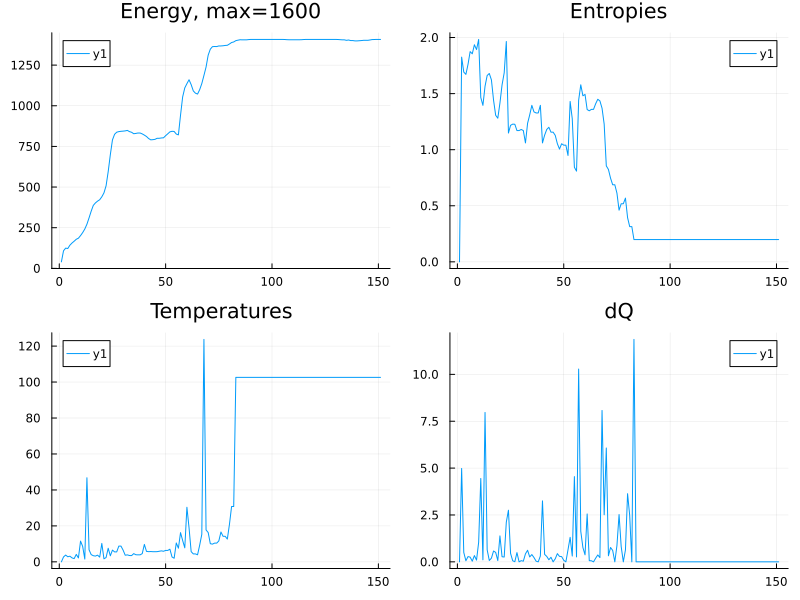

In [87]:
p1 = Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy, max=$(40^2)" )

S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["S"]
p2 = Plots.plot( S_vals, title="Entropies" )

T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["T"]
p3 = Plots.plot( T_vals, title="Temperatures" )

dQ_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["dQ"]
p4 = Plots.plot( dQ_vals, title="dQ" )

p = Plots.plot(p1,p2,p3,p4, size=(800,600))
savefig(p,"EnergyEntropyTemperatureHeat.png")
display(p)

In [76]:
e_p_array = model_df[ :, :Model_Thermo_State] .|> x -> x["e_p_array"]
e_p_array;

In [77]:
#S_vals_smoothed = moving_average(S_vals, 15)
smoothed_S_vals = exponential_moving_average(S_vals, 0.1)

t = 1:length(S_vals)  # Define the time or step points
itp = interpolate(S_vals, BSpline(Cubic(Interpolations.Line(OnGrid()))))  # Create the interpolation object
S_vals_spline = [itp[x] for x in t];  # Evaluate the spline at each point

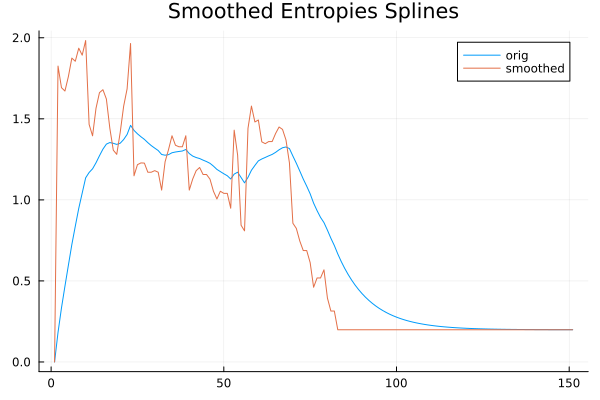

In [89]:
p = Plots.plot( [smoothed_S_vals S_vals_spline], labels=["orig" "smoothed"], title="Smoothed Entropies Splines" )
savefig(p,"SmoothedEntropiesSplines.png")
display(p)

In [90]:
t = 1:length(S_vals)
model = loess(t, S_vals, span=0.3)
S_vals_loess = [predict(model, x) for x in t];

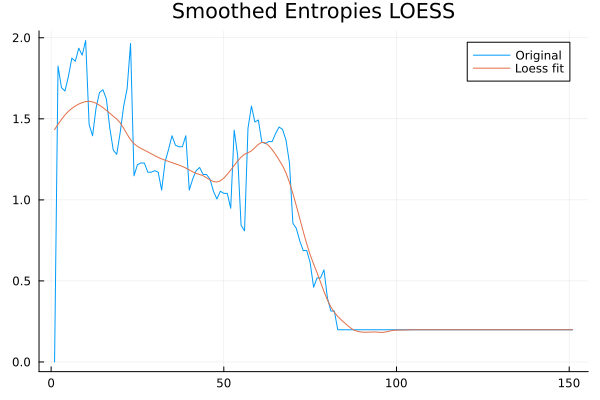

In [91]:
Plots.plot(t, S_vals, label = "Original")
p = Plots.plot!(t, S_vals_loess, label = "Loess fit", title="Smoothed Entropies LOESS")

savefig(p,"SmoothedEntropiesLOESS.png")
display(p)

In [92]:
temperatures = [Model_Temperature(e_p_array[i]) for i in 1:length(e_p_array)];

t = 1:length(temperatures)
model = loess(t, temperatures, span=0.3)
T_vals_loess = [predict(model, x) for x in t];

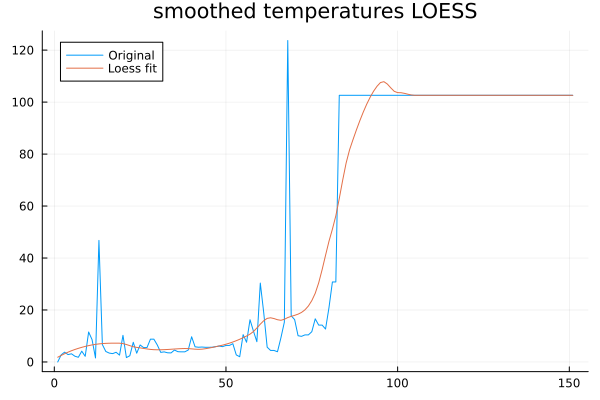

In [93]:
Plots.plot(t, temperatures, label = "Original")
p = Plots.plot!(t, T_vals_loess, label = "Loess fit", title="smoothed temperatures LOESS")

savefig(p,"SmoothedTemperaturesLOESS.png")
display(p)

In [94]:
smoothed_heat = [0.0]  # Initialize with zero for the first step where the previous state is not available

for i in 2:length(T_vals_loess)
    dS = S_vals_loess[i] - S_vals_loess[i - 1]
    dQ = Model_Heat(S_vals_loess[i], S_vals_loess[i - 1], T_vals_loess[i])
    push!(smoothed_heat, dQ)
end

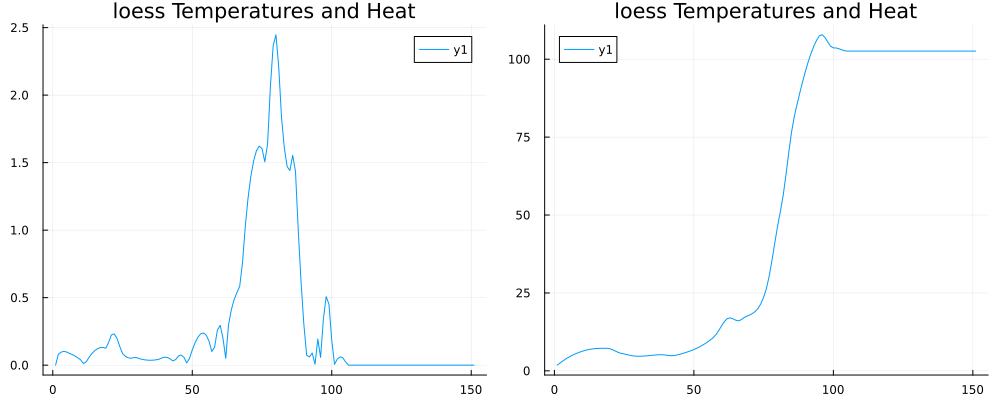

In [95]:
p1 = Plots.plot(smoothed_heat, title="heat")
p2 = Plots.plot(T_vals_loess, title="temp")
p = Plots.plot(p1,p2, size=(1000,400), title="loess Temperatures and Heat")

savefig(p,"SmoothedLOESStemperaturesHeat.png")
display(p)

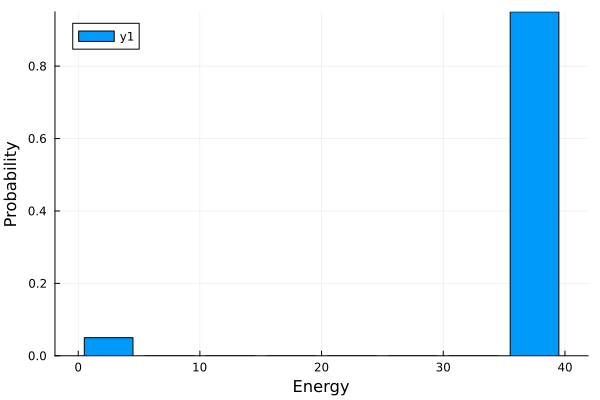

In [85]:
i = 90
energies = [pair[1] for pair in e_p_array[i]]
probabilities = [pair[2] for pair in e_p_array[i]]
Plots.plot(energies, probabilities, xlabel="Energy", ylabel="Probability", seriestype=:bar)


In [69]:
function smooth_distributions(e_p_array, window_size)
    smoothed_distributions = []

    for i in 1:length(e_p_array)
        # Determine the range of indices to include in the smoothing
        start_idx = max(1, i - window_size + 1)
        end_idx = i
        window = e_p_array[start_idx:end_idx]

        # Aggregate all energy levels present in the window
        all_energies = sort(union([pair[1] for dist in window for pair in dist]))

        # Initialize a dictionary to accumulate probabilities for each energy level
        energy_prob_accum = Dict((e, 0.0) for e in all_energies)

        # Sum probabilities for each energy level across the distributions in the window
        for dist in window
            for (e, p) in dist
                energy_prob_accum[e] += p / length(window)  # Average contribution from each distribution
            end
        end

        # Normalize the distribution
        total_prob = sum(values(energy_prob_accum))
        if total_prob > 0
            normalized_dist = [(e, p / total_prob) for (e, p) in energy_prob_accum]
        else
            normalized_dist = [(e, 0) for e in all_energies]  # Handle the case of total_prob being 0
        end

        push!(smoothed_distributions, normalized_dist)
    end

    return smoothed_distributions
end


smooth_distributions (generic function with 1 method)

In [70]:
smoothed_e_p_array = smooth_distributions(e_p_array, 10);

In [71]:
smoothed_temperatures = [Model_Temperature(smoothed_dist) for smoothed_dist in smoothed_e_p_array];

In [72]:
smoothed_heat = [0.0]  # Initialize with zero for the first step where the previous state is not available

for i in 2:length(smoothed_temperatures)
    dS = S_vals_loess[i] - S_vals_loess[i - 1]
    dQ = Model_Heat(S_vals_loess[i], S_vals_loess[i - 1], smoothed_temperatures[i])
    push!(smoothed_heat, dQ)
end

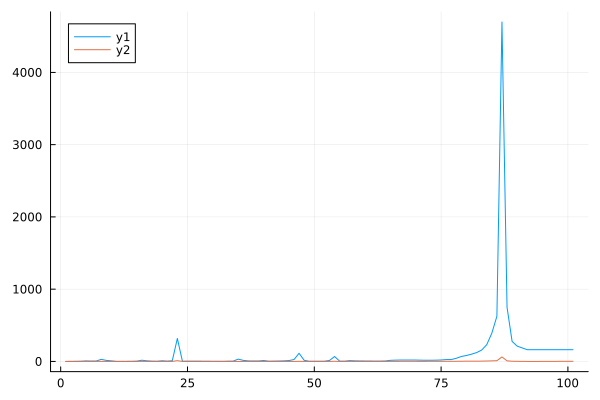

In [73]:
Plots.plot( smoothed_temperatures )
Plots.plot!(smoothed_heat)

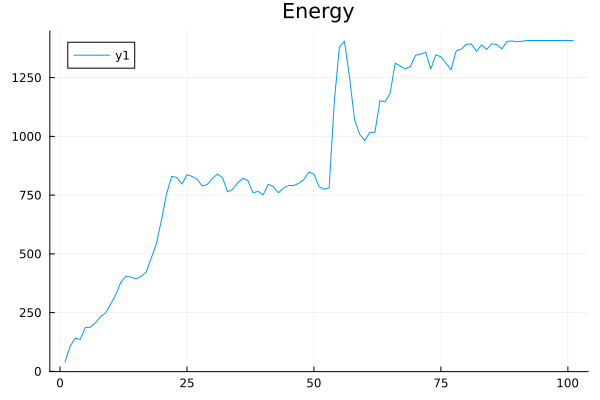

In [36]:
Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy" )

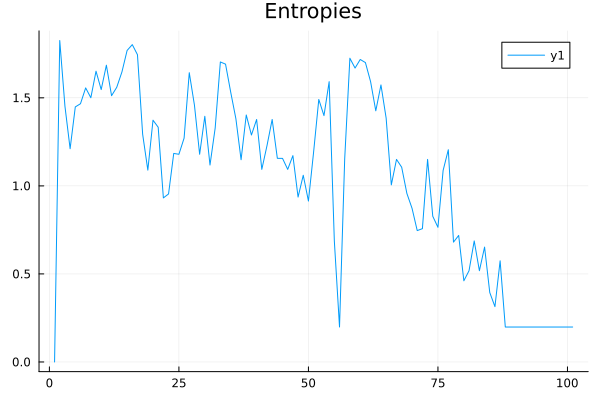

In [37]:
S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["S"]
Plots.plot( S_vals, title="Entropies" )

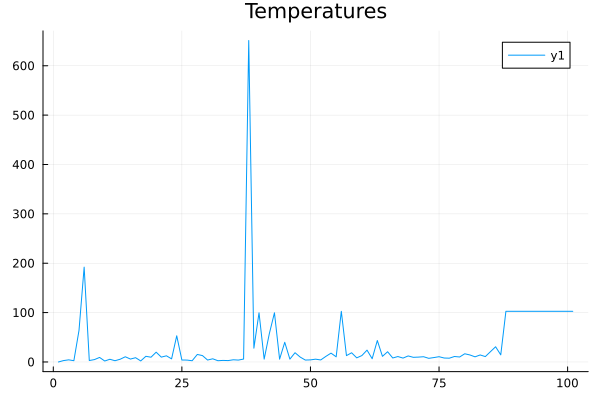

In [38]:
T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["T"]
Plots.plot( T_vals, title="Temperatures" )

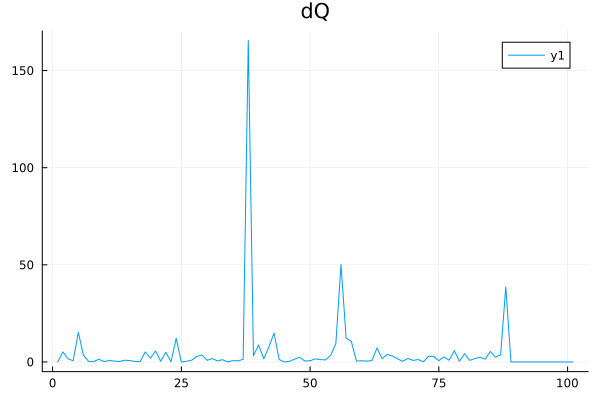

In [39]:
dQ_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["dQ"]
Plots.plot( dQ_vals, title="dQ" )

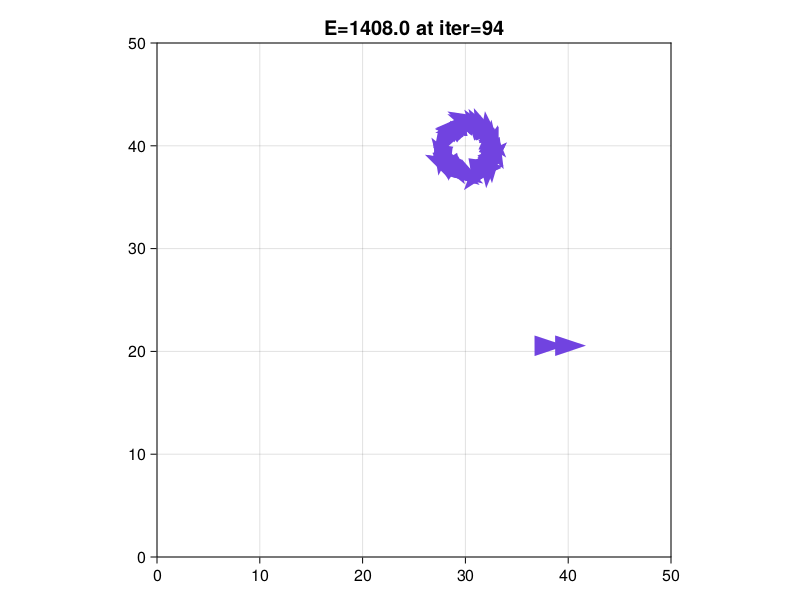

In [40]:
model_df[ 95, :Flock_Model_State]